In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
orig = cv.imread("/content/drive/My Drive/food/training/food/856.jpg") 

In [27]:
# Convert image to RGB from BGR (another way is to use "image = image[:, :, ::-1]" code)
orig = cv.cvtColor(orig, cv.COLOR_BGR2RGB)

# Resize image to 224x224 size
image = cv.resize(orig, (224, 224)).reshape(-1, 224, 224, 3)

# We need to preprocess imageto fulfill ResNet50 requirements
image = preprocess_input(image)

# Extracting our features
features = model.predict(image)

features.shape

n_features = features.shape[-1]

fig = plt.figure(figsize = (17, 8))
gs = gridspec.GridSpec(1, 2, figure = fig)
sub_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(orig)

for i in range(3):
    for j in range(3):
        ax2 = fig.add_subplot(sub_gs[i, j])
        plt.axis('off')        
        plt.imshow(features[0, :, :, np.random.randint(n_features)], cmap = 'gray')

(1, 7, 7, 2048)

In [30]:
# Path to splits
path = '/content/drive/My Drive/food'

# List of splts: ['training', 'validation', 'evaluation']
sets = os.listdir(path)

# Arrays to store data
train_X, train_Y = ([], [])
val_X, val_Y = ([], [])
eval_X, eval_Y = ([], [])

data = [(train_X, train_Y), (val_X, val_Y), (eval_X, eval_Y)]

# Loop through all splits
for s, d in (zip(sets, data)):
    # Defining path to categories ['non_food', 'food']
    path_to_cat = os.path.join(path, s)
    
    # Loop through categories in split
    for cat in os.listdir(path_to_cat):
        # Defining path to images in category
        path_to_images = os.path.join(path_to_cat, cat)
        
        # Defining labels
        if cat == 'food':
            label = 1
        else:
            label = 0
        
        # Loop through images in category
        for i in os.listdir(path_to_images):
            # Path to image
            image_path = os.path.join(path_to_images, i)
            
            # Reading and preprocessing image
            image = cv.imread(image_path)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (224, 224)).reshape(-1, 224, 224, 3)
            image = preprocess_input(image)
            
            # Extracting features
            features = model.predict(image).reshape(100352)
            
            # Store features and label in our lists
            d[0].append(features)
            d[1].append(label)


In [31]:
# Shuffle data in each split
random_state = 666
train_X, train_Y = shuffle(train_X, train_Y, random_state = random_state)
val_X, val_Y = shuffle(val_X, val_Y, random_state = random_state)
eval_X, eval_Y = shuffle(eval_X, eval_Y, random_state = random_state)

In [32]:
# Convert data to numpy arrays
train_X = np.array(train_X)
train_Y = np.array(train_Y)

val_X = np.array(val_X)
val_Y = np.array(val_Y)

eval_X = np.array(eval_X)
eval_Y = np.array(eval_Y)

In [35]:
# Creating model
# Number of nodes were defined using rule: 
# take the square root of the previous number of nodes in the layer and then find the closest power of 2
# (Before FC layers in ResNet50 we have 7*7*2048 = 100352 nodes (after flatten layer), so if we take square root from
# this number we get 316.78 and closes power of 2 is 256, it's number of nodes in 1st FC layer in our network, 
# to define number of nodes in second layer we are getting swuare root from 256 = 16)
# Number of nodes in last layer = 1, because it's binary classification problem and our labels have only two values 0 and 1

model = Sequential()
model.add(Dense(256, input_shape = (100352,), activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(1, activation = 'sigmoid'))

# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(train_X, train_Y, batch_size = 64, epochs = 10, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/10
16/16 [==============================] - 5s 286ms/step - loss: 3.5555 - accuracy: 0.7564 - val_loss: 1.5104 - val_accuracy: 0.9760

Epoch 00001: val_accuracy improved from -inf to 0.97600, saving model to best_model.hdf5
Epoch 2/10
16/16 [==============================] - 4s 272ms/step - loss: 0.1488 - accuracy: 0.9935 - val_loss: 1.3240 - val_accuracy: 0.9670

Epoch 00002: val_accuracy did not improve from 0.97600
Epoch 3/10
16/16 [==============================] - 4s 270ms/step - loss: 0.1160 - accuracy: 0.9919 - val_loss: 1.6534 - val_accuracy: 0.9780

Epoch 00003: val_accuracy improved from 0.97600 to 0.97800, saving model to best_model.hdf5
Epoch 4/10
16/16 [==============================] - 4s 271ms/step - loss: 8.9948e-04 - accuracy: 0.9998 - val_loss: 1.1889 - val_accuracy: 0.9790

Epoch 00004: val_accuracy improved from 0.97800 to 0.97900, saving model to best_model.hdf5
Epoch 5/10
16/16 [==============================] - 4s 273ms/step - loss: 0.0062 - accuracy: 0.9

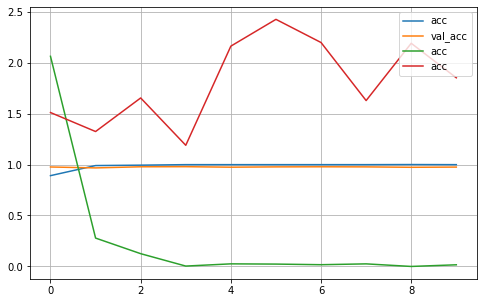

In [36]:
# Plot losses and accuracies
history = model.history.history

fig = plt.figure(figsize = (8, 5))
plt.plot(history['accuracy'], label = 'acc')
plt.plot(history['val_accuracy'], label = 'val_acc')
plt.plot(history['loss'], label = 'acc')
plt.plot(history['val_loss'], label = 'acc')
plt.grid()
plt.legend()
plt.show()

In [37]:
# Loading best model and evaluate it
# Here I want to compare keras.evaluate and sklearn.accuracy_score methods
model.load_weights('best_model.hdf5')
model.evaluate(eval_X, eval_Y)

94/94 [==============================] - 4s 46ms/step - loss: 0.7976 - accuracy: 0.9833


[0.7975539565086365, 0.9833333492279053]

Accuracy: 98.3333%


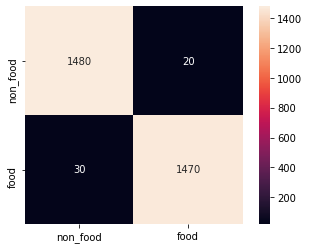

In [38]:
# Making predictions using evaluation dataset
preds = model.predict(eval_X)

# If our prediction more than 0.5 - we round it to 1, else to 0
preds = [1 if i > 0.5 else 0 for i in preds]

# Calculating accuracy score
accuracy = accuracy_score(eval_Y, preds)
print(f'Accuracy: {round(accuracy * 100, 4)}%')

# Plotting confusion matrix
l = ['non_food', 'food']
confusion = confusion_matrix(eval_Y, preds)
sns.heatmap(confusion, square = True, fmt = 'd', xticklabels = l, yticklabels = l, annot = True)